## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.special import gamma, factorial

**The Simulation of Multiparameter Karlin Stable processes has two parts, the small-jump part and large-jump part**

### Small-jump part
This part contains two functions:      
1. multi_one_oov(n, beta)
   - Input:
      - n: $n^2$ is the number of points in the simulation
      - beta: $\beta \in (0, 1)$
   - Output:
      - one copy of odd-occupancy vector from indicator method

2. multi_fBm(n, H)
   - Input:
      - n: $n^2$ is the number of points in the simulation
      - H: Hurst parameter
   - Output: 
      - approximated multiparameter fractional Brownian motion on $[0, 1]\times[0, 1]$

### Large-jump part:
This part contains one functions:
1. multi_large_jump(n, alpha, beta)
   - Input:
      - n: $n**2$ is the number of points on unit disk $[0, 1]\times[0, 1]$
      - alpha: $\alpha \in (0, 2)$
      - beta: $\beta \in (0, 1)$
   - Output:
      - Y2: the large-jump part

**Once the simulations of small-jump part and large-jump part completed separately, we combine them to obtain the multiparameter Karlin stable processes and produce some plots**
1. multi_plt_params(t1, t2, Y)
   - Input:
      - t1: a regular lattice on horizontal axis over $[0, 1]$
      - t2: a regular lattice on vertical axis over $[0, 1]$
      - Y: the process for plotting
    - Output:
      - fig: a well-defined plot on $[0, 1]\times[0,1]$
      
2. multi_KSP(n, alpha, beta)
   - Input:
      - n: $n**2$ is the number of points on unit disk $[0, 1]\times[0, 1]$
      - alpha: $\alpha \in (0, 2)$
      - beta: $\beta \in (0, 1)$ 
   - Output:
      - Y1: small-jump part
      - Y2: large-jump part
      - Y: combined of small and large jumps

In [2]:
def multi_one_oov(n, beta, flattened = False):
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1, 1), np.random.gamma(beta, 1, 1), np.random.gamma(1-beta, 1, 1)
    Lambda = ga_1*ga_1beta/ga_beta
    
    t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
    t_1, t_2 = np.meshgrid(t1, t2)
    
    u_x, u_y = np.random.uniform(0, 1, 1), np.random.uniform(0, 1, 1)
    ind1 = np.where((u_x < t_1) & (u_y < t_2), 1, 0)
    
    proba = 0.5*(1-np.exp(-(2/n**2)*Lambda))
    inddd = np.random.binomial(1, proba, (n+1)**2).reshape(n+1, n+1)
    ind2 = inddd.cumsum(axis = 0).cumsum(axis = 1)
    
    if flattened == False:
        return (ind1 + ind2) % 2
    else:
        return ((ind1 + ind2) % 2).flatten()

def multi_fBm(n, H, m = 2500):
    D1 = np.zeros(((n+1)**2, m))
    
    for i in range(0, m):
        D1[:, i] = multi_one_oov(n, 2*H, flattened = True)
    
    e = np.random.normal(0, 1, m)
    return np.sqrt(2**(1-2*H))*(1/np.sqrt(m))*np.sum(D1*e, axis=1).reshape(n+1, n+1)

def multi_large_jump(N, n, alpha, beta, epsilon): 
    D2 = np.zeros(((n+1)**2, N))
    for i in range(0, N):
        D2[:, i] = multi_one_oov(n, beta, flattened = True)
    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha)))
    return np.sum(D2*V, axis=1).reshape(n+1, n+1)


def multi_KSP(n, alpha, beta, m = 2500):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.000001
    nu_epsilon = 2**(1-beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1)) 
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2) 
    
    Y1 = sigma_epsilon*multi_fBm(n, beta/2, m)
    Y2 = multi_large_jump(N, n, alpha, beta, epsilon=epsilon)
    return Y1, Y2, Y1+Y2


## Plots and tests

In [3]:
##YZ: sample a single OOV
n = 300
beta = 0.5

t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)

OOV = multi_one_oov(n,beta,flattened = False)

import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=OOV,
                   x=t1,
                   y=t2,
                   colorscale='Greys'))
fig.update_layout(title="β=" + str(beta),
            height=800, width=800)
fig.show()

## I don't why I can't use both latex and str function in the title at the same time, so I just copy paste a \beta there for now

In [4]:
import matplotlib.pyplot as plt

n = 300
beta = 0.2

OOV = multi_one_oov(n,beta,flattened = False)

plt.figure(figsize = (3, 3))
#plt.rc('font', size=32)
im = plt.imshow(1-OOV, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
## add a color bar
##plt.colorbar(im) 

plt.title(r"$\beta$="+str(beta))
plt.tight_layout()
plt.savefig('mfsm_OOV_beta'+str(beta)+'.pdf')

plt.show()

<Figure size 300x300 with 1 Axes>

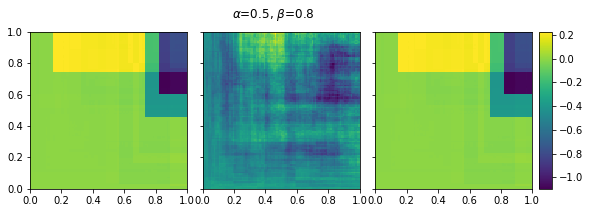

In [5]:
import matplotlib.pyplot as plt

n = 100
alpha = 0.5
beta = 0.8

Y1, Y2, Y = multi_KSP(n, alpha, beta, m = 2500)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
plt.subplots_adjust(wspace = 0.1)
axs[0].imshow(Y2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1].imshow(Y1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im = axs[2].imshow(Y, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
plt.colorbar(im, cax=cax) 

fig.suptitle(r"$\alpha$=" + str(alpha) + r", $\beta$=" + str(beta))
plt.savefig('mfsm_alpha'+str(alpha)+'_beta'+str(beta)+'.pdf',bbox_inches = 'tight')

plt.show()

## Four Plots

In [16]:
n = 300
alpha = 1.2
beta = 0.2

Y11, Y21, Y1 = multi_KSP(n, alpha, beta, m = 2500)

In [17]:
n = 300
alpha = 1.2
beta = 0.8

Y12, Y22, Y2 = multi_KSP(n, alpha, beta, m = 2500)

In [18]:
n = 300
alpha = 1.8
beta = 0.2

Y13, Y23, Y3 = multi_KSP(n, alpha, beta, m = 2500)

In [19]:
n = 300
alpha = 1.8
beta = 0.8

Y14, Y24, Y4 = multi_KSP(n, alpha, beta, m = 2500)

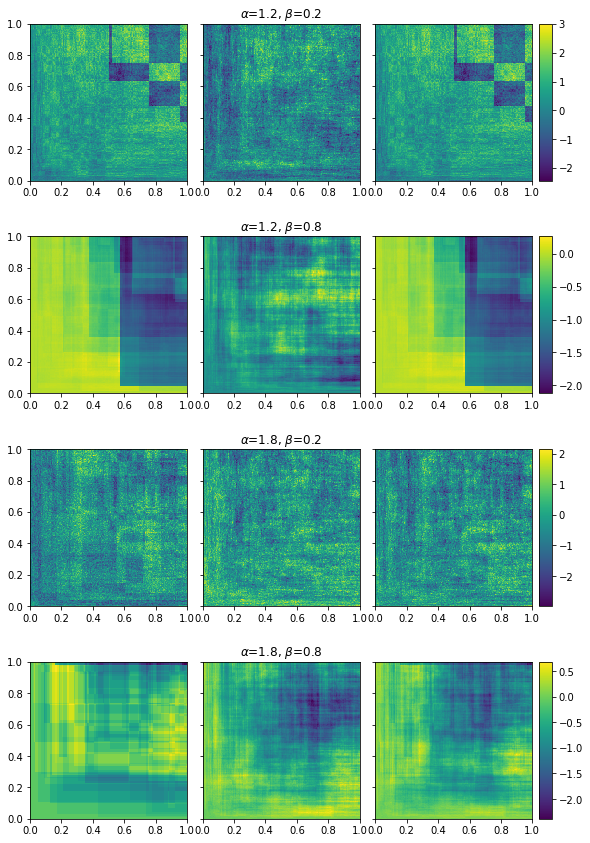

In [20]:
fig, axs = plt.subplots(4, 3, figsize=(9, 15), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)
axs[0,0].imshow(Y21, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[0,1].imshow(Y11, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im1 = axs[0,2].imshow(Y1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax1 = fig.add_axes([axs[0,2].get_position().x1+0.01,axs[0,2].get_position().y0,0.02,axs[0,2].get_position().height])
plt.colorbar(im1, cax=cax1) 

axs[1,0].imshow(Y22, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1,1].imshow(Y12, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im2 = axs[1,2].imshow(Y2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax2 = fig.add_axes([axs[1,2].get_position().x1+0.01,axs[1,2].get_position().y0,0.02,axs[1,2].get_position().height])
plt.colorbar(im2, cax=cax2) 

axs[2,0].imshow(Y23, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[2,1].imshow(Y13, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im3 = axs[2,2].imshow(Y3, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax3 = fig.add_axes([axs[2,2].get_position().x1+0.01,axs[2,2].get_position().y0,0.02,axs[2,2].get_position().height])
plt.colorbar(im3, cax=cax3) 

axs[3,0].imshow(Y24, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[3,1].imshow(Y14, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
im4 = axs[3,2].imshow(Y4, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])

## add a color bar
cax4 = fig.add_axes([axs[3,2].get_position().x1+0.01,axs[3,2].get_position().y0,0.02,axs[3,2].get_position().height])
plt.colorbar(im4, cax=cax4) 

axs[0,1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.2")
axs[1,1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.8")
axs[2,1].set_title(r"$\alpha$=1.8" + r", $\beta$=0.2")
axs[3,1].set_title(r"$\alpha$=1.8" + r", $\beta$=0.8")

plt.savefig('Figure6.pdf', bbox_inches = 'tight')


plt.show()